# Functions to get the Aggregated Volumes

In [19]:
import requests
import csv
import pandas as pd
import time

def fetch_aggregated_volumes(ticker, start_date, end_date):
    """
    Fetches aggregated volumes for the given stock ticker and date range.

    Args:
    - ticker (str): The stock ticker symbol.
    - start_date (str): The start date in the format 'YYYY-MM-DD'.
    - end_date (str): The end date in the format 'YYYY-MM-DD'.

    Returns:
    - pd.DataFrame: A DataFrame containing aggregated volumes with timestamps as index.
    """
    # API query parameters
    api_key = "RLH5skiQVl24hXBE2IyPT3JBDmorI4r0"
    interval_minutes = 15  # Assuming interval of 15 minutes
    

    # Initialize a dictionary to store volumes for each timestamp
    volume_data = {}
    # Construct initial API query URL
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/15/minute/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
    params = {
            'apiKey': api_key
        }
    # Fetch data until end date or no more next_url
    while url:
        # Make the API request
        response = requests.get(url, params=params)
        
        # Check if the request was successful
        if response.status_code == 200:
            # Load JSON data from the response
            data = response.json()
            results = data["results"]

            # Iterate through results and convert timestamps to readable times
            for result in results:
                timestamp = result["t"]
                volume = result["v"]
                num_trades = result["n"]
                timestamp_et = pd.to_datetime(timestamp, unit='ms', utc=True).tz_convert('America/New_York')
                timestamp_str = timestamp_et.strftime("%Y-%m-%d %H:%M:%S")
                volume_data[timestamp_str] = {"volume": volume, "num_trades": num_trades}

            # Update URL for next page if available
            url = data.get('next_url')

            # Delay to comply with rate limit (5 requests per minute)
            time.sleep(12)  # Sleep for 12 seconds between each request

        else:
            print(f"Failed to fetch data. Status code: {response.status_code}")
            break

    # Convert dictionary to DataFrame
    df = pd.DataFrame(volume_data).T

    # Save DataFrame to CSV
    df.to_csv(f"{ticker}_aggregated_volumes.csv")

    return df

In [20]:
tickers = ['AMZN', 'MSFT', 'TSLA', 'GOOG', 'NVDA', 'META', 'AAPL', 'QQQ', 'SPY', 'AMD']
start_date = '2023-01-01'
end_date = '2024-02-18'
for ticker in tickers: 
    volumes = fetch_aggregated_volumes(ticker, start_date, end_date)

# Function to Plot the Volume and Trades

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def plot_volume_and_trades(df, ticker):
    """
    Plots the average volume and number of trades for each 15-minute interval.

    Args:
    - df (DataFrame): DataFrame containing columns 'volume' and 'num_trades'.
                      The DataFrame should have timestamps as the index.
    """
    # Calculate the averages
    readable_timestamps = []
    for hour in range(9, 17):  # Trading hours from 9:00 to 16:00
        for minute in range(0, 60, 15):
            timestamp = f"{hour:02d}:{minute:02d}"
            readable_timestamps.append(timestamp)

    volume_data = {timestamp: {'volumes': [], 'num_trades': []} for timestamp in readable_timestamps}

    for index, row in df.iterrows():
        values = row[0].split(',')
        timestamp = values[0]
        volume = float(values[1])
        num_trades = float(values[2])

        datetime_obj = pd.to_datetime(timestamp)
        timestamp_str = datetime_obj.strftime("%H:%M")

        if timestamp_str in readable_timestamps:
            volume_data[timestamp_str]['volumes'].append(volume)
            volume_data[timestamp_str]['num_trades'].append(num_trades)

    # Calculate averages for each interval
    avg_volume = [sum(data['volumes']) / len(data['volumes']) if data['volumes'] else 0 for data in volume_data.values()]
    avg_num_trades = [sum(data['num_trades']) / len(data['num_trades']) if data['num_trades'] else 0 for data in volume_data.values()]

    # Plot the averages
    plt.figure(figsize=(12, 6))

    # Plot the average volume
    plt.plot(readable_timestamps, avg_volume, label='Average Volume', marker='o')

    # Plot the average number of trades
    plt.plot(readable_timestamps, avg_num_trades, label='Average Number of Trades', marker='o', color='orange')

    # Add labels, title, and legend
    plt.xlabel('Time of the Day (HH:MM)')
    plt.ylabel('Average Volume / Average Number of Trades')
    plt.title(f'Average Volume and Average Number of Trades for Each 15-minute Interval {ticker}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return avg_volume, avg_num_trades

# Function to Analyze Statistically Significant Times

In [126]:
import numpy as np

def analyze_volumes(avg_volumes, avg_trades, threshold):
    """
    Analyzes the average volumes and number of trades for each 15-minute interval and returns times above a certain threshold.

    Args:
    - avg_volumes (list): A list of average volumes for each 15-minute interval.
    - avg_trades (list): A list of average number of trades for each 15-minute interval.
    - threshold (float): The absolute threshold value for both volume and trades significance.

    Returns:
    - list: A list of timestamps where both volume and trades significance are above the threshold.
    """     
    significant_times = []

    # Calculate overall average and standard deviation
    overall_avg_volume = np.mean(avg_volumes)
    overall_std_volume = np.std(avg_volumes)
    overall_avg_trades = np.mean(avg_trades)
    overall_std_trades = np.std(avg_trades)

    # Calculate statistical significance for each interval
    volume_significance = (np.array(avg_volumes) - overall_avg_volume) / overall_std_volume
    trades_significance = (np.array(avg_trades) - overall_avg_trades) / overall_std_trades

    # Check if both volume and trades significance are above the threshold and add corresponding times to the list
    for i, (volume_significance_val, trades_significance_val) in enumerate(zip(volume_significance, trades_significance)):
        if abs(volume_significance_val) > threshold and abs(trades_significance_val) >= threshold:
            # Assuming the timestamp format is 'HH:MM' based on the previous code
            timestamp = f"{9 + i // 4:02d}:{i % 4 * 15:02d}"
            significant_times.append(timestamp)

    return significant_times

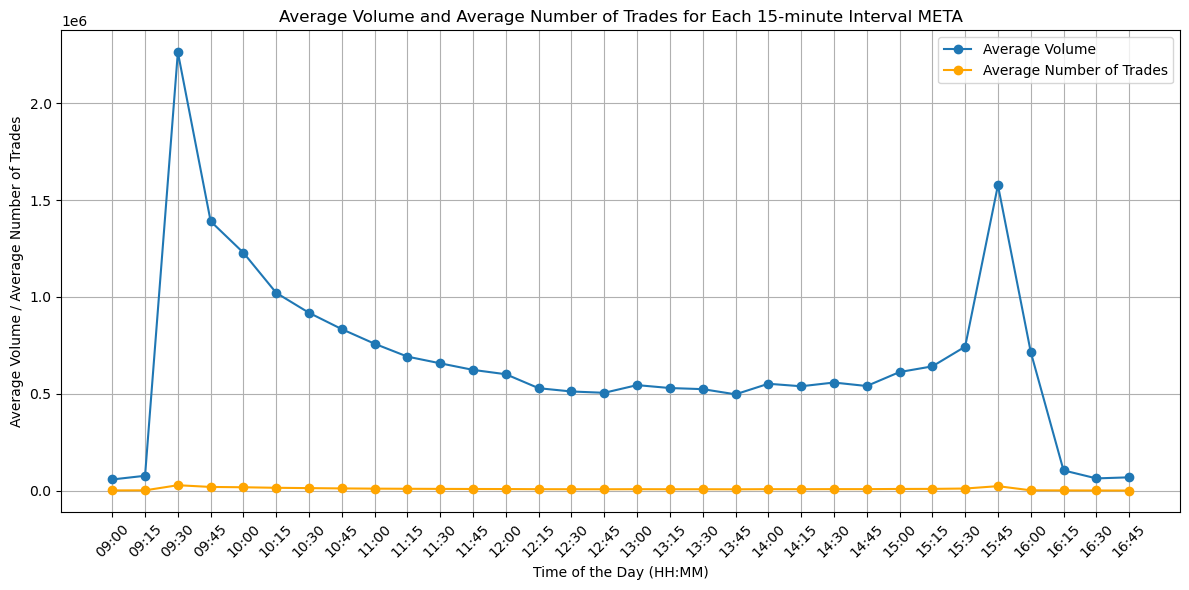

significant times for META
['09:30', '09:45', '15:45']


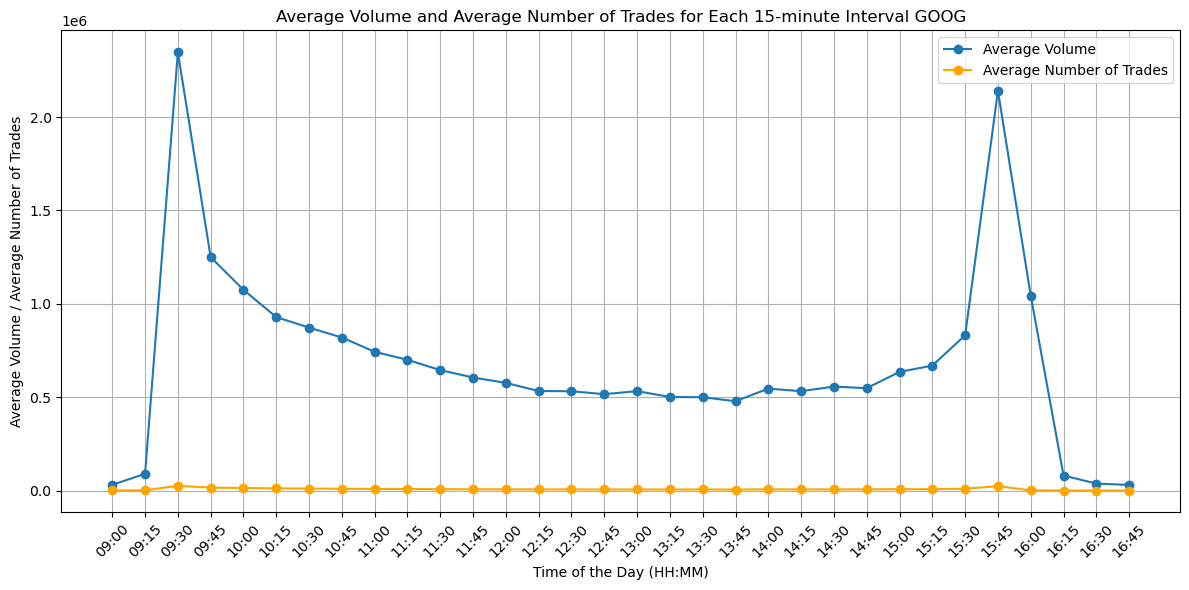

significant times for GOOG
['09:30', '15:45']


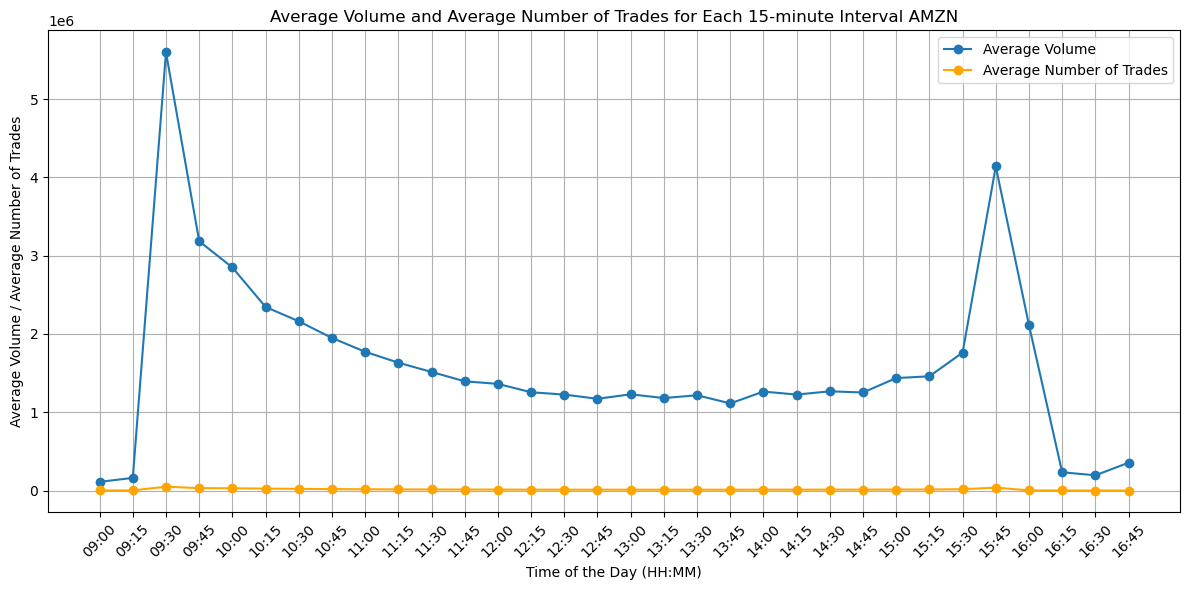

significant times for AMZN
['09:30', '15:45']


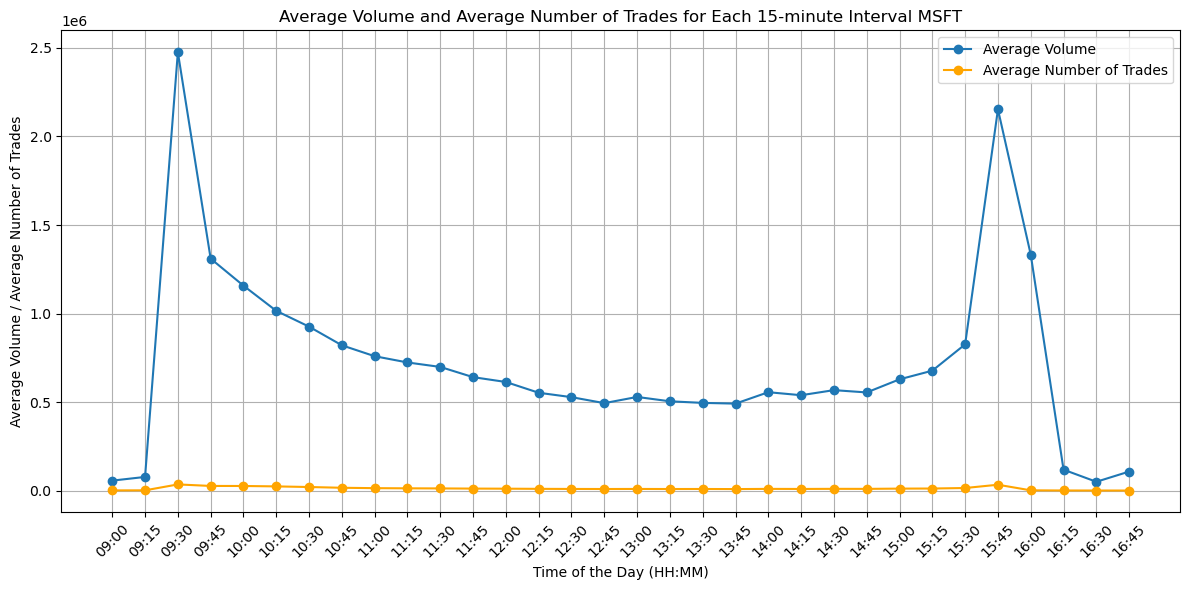

significant times for MSFT
['09:30', '15:45']


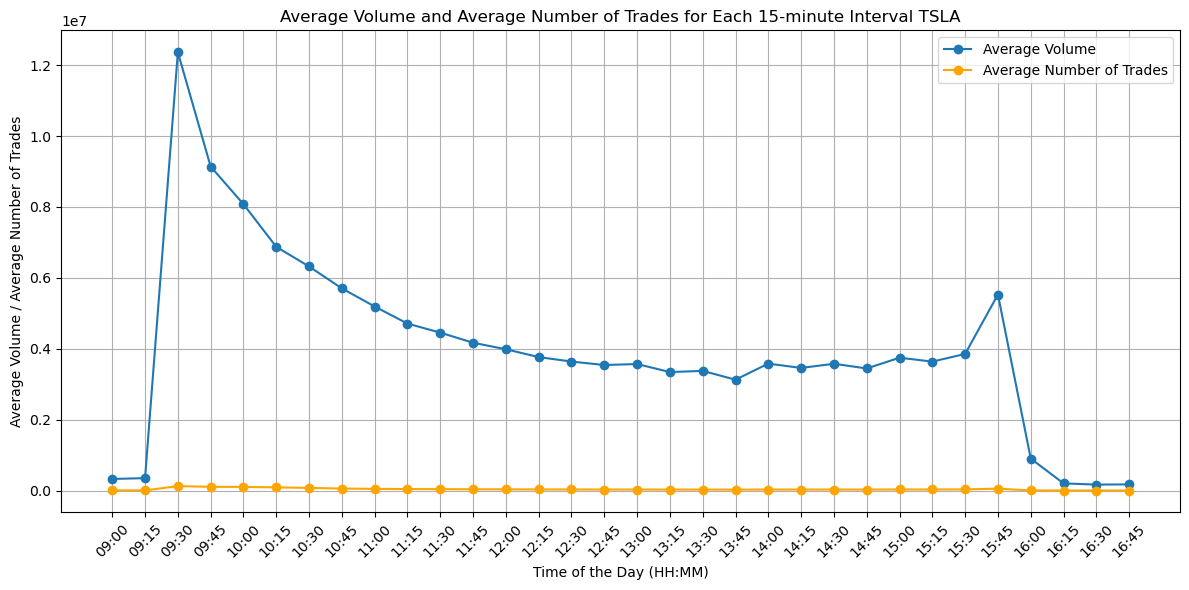

significant times for TSLA
['09:30', '09:45', '10:00']


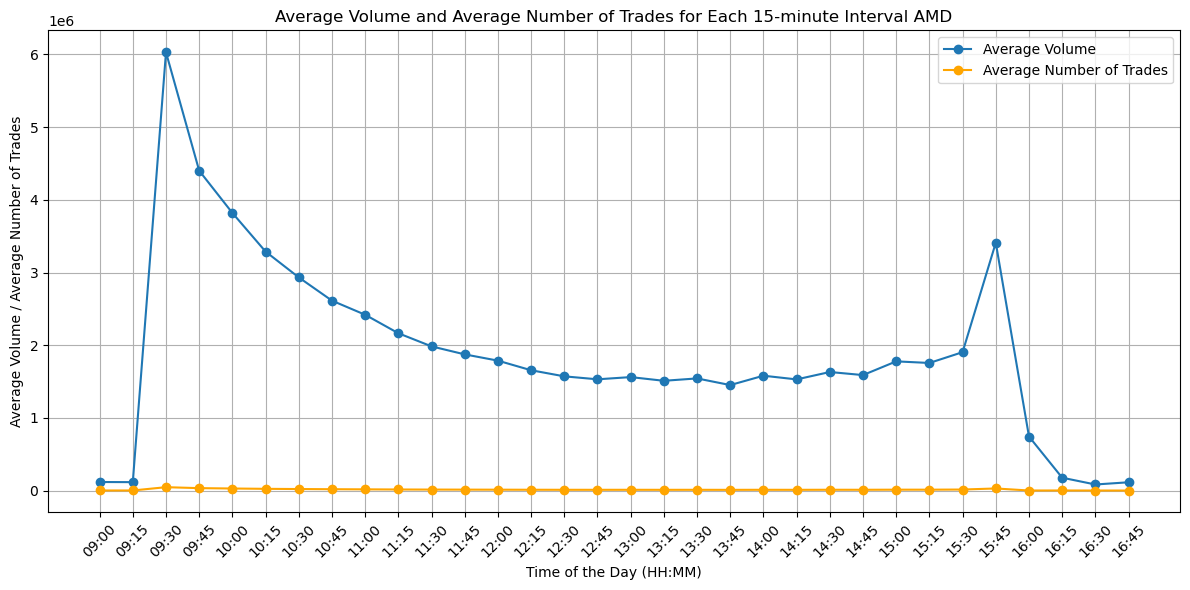

significant times for AMD
['09:30', '09:45']


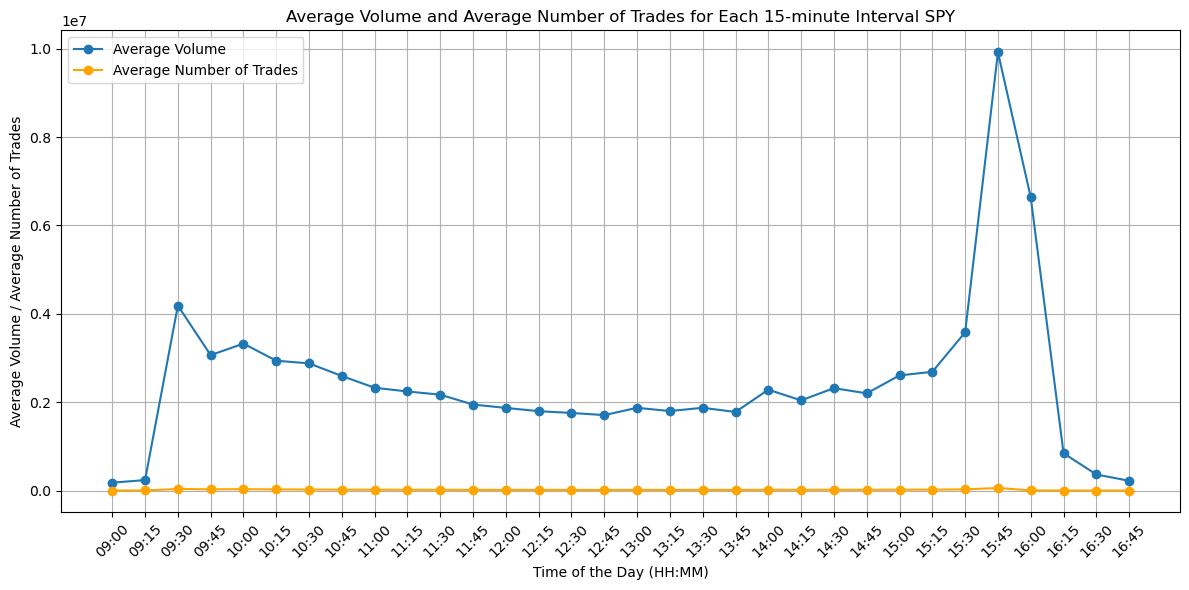

significant times for SPY
['15:45']


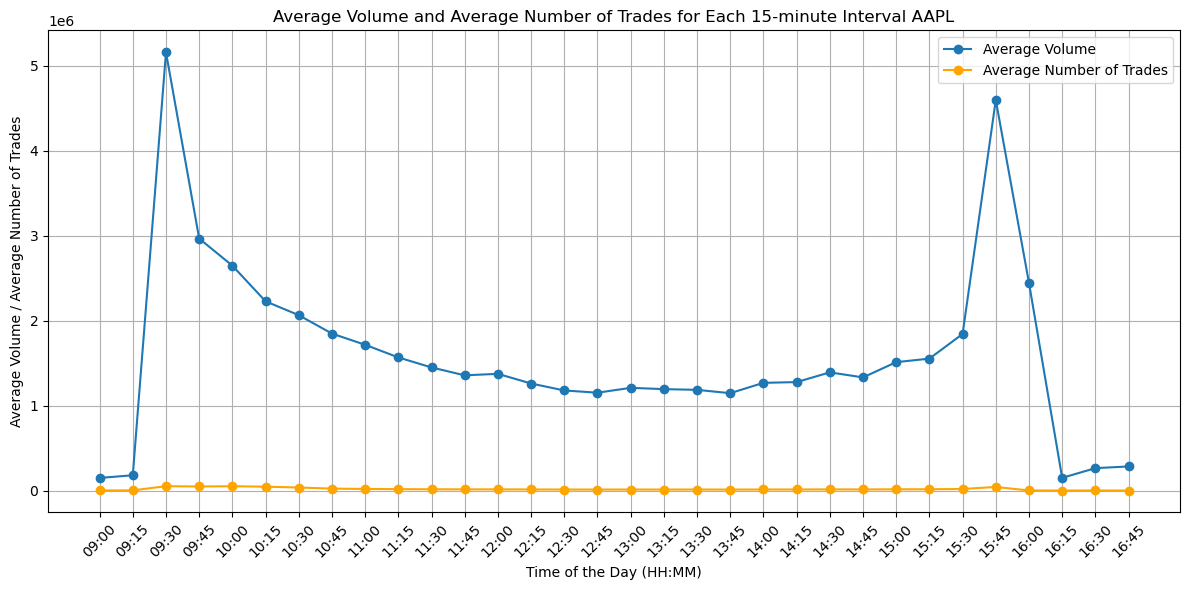

significant times for AAPL
['09:30', '15:45']


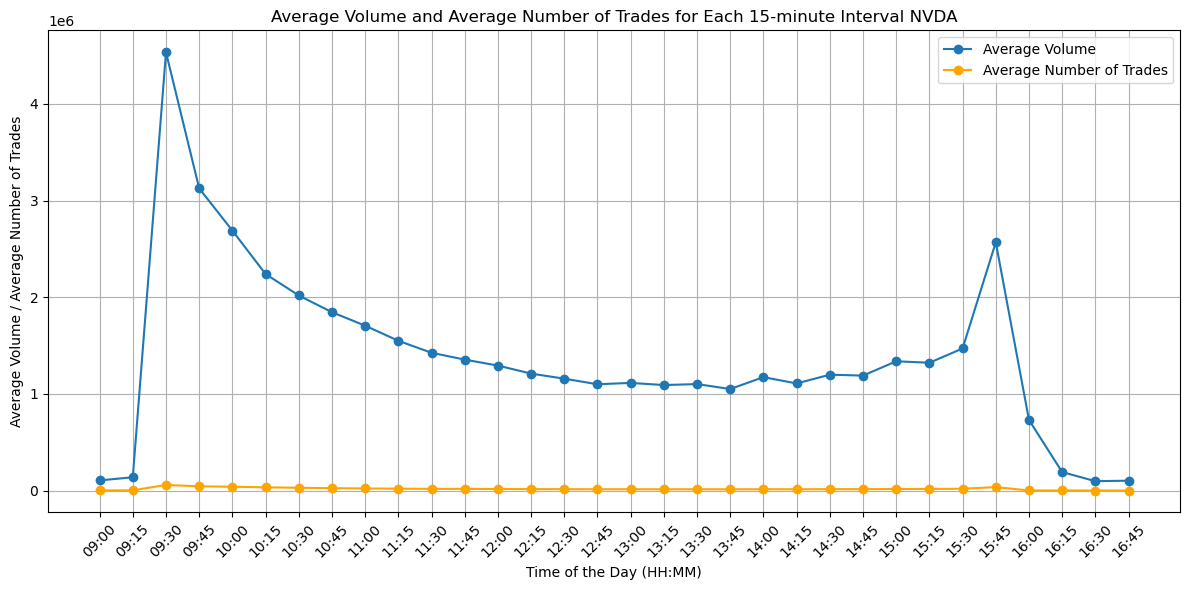

significant times for NVDA
['09:30', '09:45']


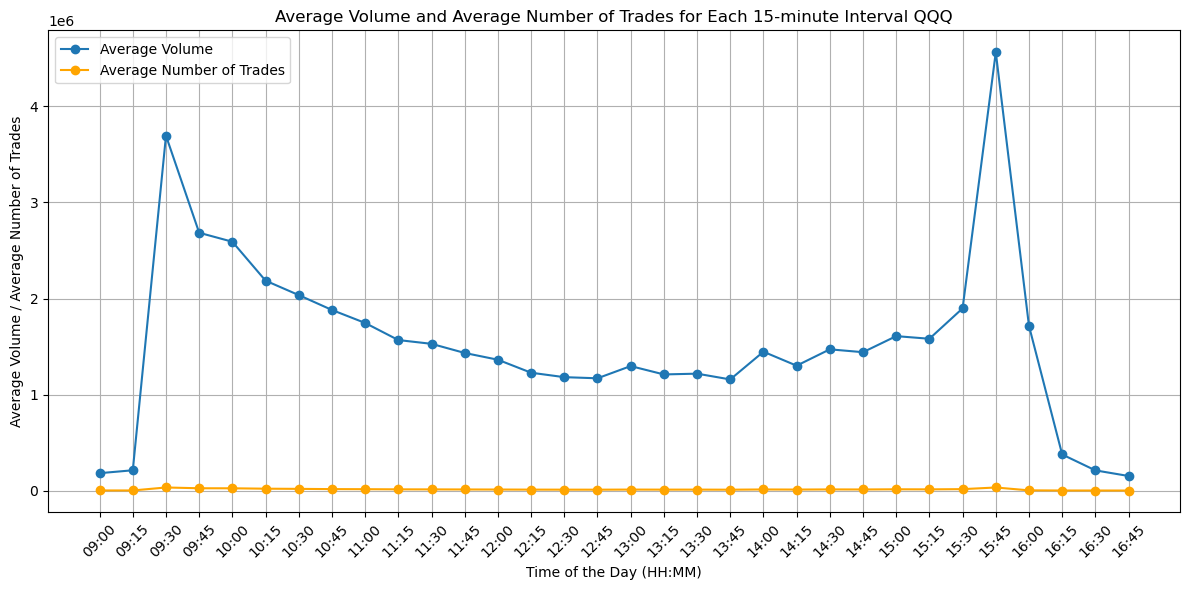

significant times for QQQ
['09:30', '15:45']


In [127]:
import os
directory = os.getcwd()
threshold = 1.5
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        ticker = filename.split('_')[0]
        df = pd.read_csv(filename, sep='\t')
        avg_volume, avg_num_trades = plot_volume_and_trades(df, ticker)
        stats = analyze_volumes(avg_volume, avg_num_trades, threshold)
        print("significant times for " + ticker)
        print(stats)